# The 3ML workflow

Generally, an analysis in 3ML is performed in 3 steps:

1. Load the data: one or more datasets are loaded and then listed in a DataList object
2. Define the model: a model for the data is defined by including one or more PointSource, ExtendedSource or ParticleSource instances
3. Perform a likelihood or a Bayesian analysis: the data and the model are used together to perform either a Maximum Likelihood analysis, or a Bayesian analysis

## Loading data

3ML is built around the concept of _plugins_. A plugin is used to load a particular type of data, or the data from a particular instrument. There is a plugin of optical data, one for X-ray data, one for Fermi/LAT data and so on. Plugins instances can be added and removed at the loading stage without changing any other stage of the analysis (but of course, you need to rerun all stages to update the results).

First, let's import 3ML:

In [2]:
from threeML import *

Let's start by loading one dataset, which in the 3ML workflow means creating an instance of the appropriate plugin:

Using chi2 statistic with the provided errors.


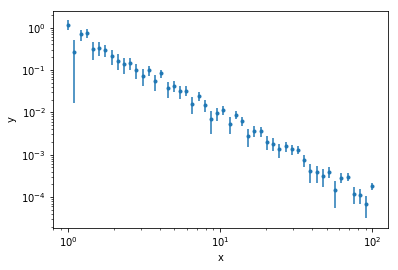

In [3]:
# Get some example data
from threeML.io.package_data import get_path_of_data_file

data_path = get_path_of_data_file("datasets/xy_powerlaw.txt")

# Create an instance of the XYLike plugin, which allows to analyze simple x,y points
# with error bars
xyl = XYLike.from_text_file("xyl", data_path)

# Let's plot it just to see what we have loaded
xyl.plot(x_scale='log', y_scale='log')

Now we need to create a DataList object, which in this case contains only one instance:

In [4]:
data = DataList(xyl)

The DataList object can receive one or more plugin instances on initialization. So for example, to use two datasets we can simply do:

In [5]:
# Create the second instance, this time of a different type

pha = get_path_of_data_file("datasets/ogip_powerlaw.pha")
bak = get_path_of_data_file("datasets/ogip_powerlaw.bak")
rsp = get_path_of_data_file("datasets/ogip_powerlaw.rsp")

ogip = OGIPLike("ogip", pha, bak, rsp)

# Now use both plugins
data = DataList(xyl, ogip)

Auto-probed noise models:
- observation: poisson
- background: poisson



WARNING UserWarning: FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.



The DataList object can accept any number of plugins in input.

You can also create a list of plugins, and then create a DataList using the "expansion" feature of the python language ('*'), like this:

In [6]:
# This is equivalent to write data = DataList(xyl, ogip)

my_plugins = [xyl, ogip]
data = DataList(*my_plugins)

This is useful if you need to create the list of plugins at runtime, for example looping over many files.

## Define the model

After you have loaded your data, you need to define a model for them. A model is a collection of one or more sources. A source represents an astrophysical reality, like a star, a galaxy, a molecular cloud... There are 3 kinds of sources: PointSource, ExtendedSource and ParticleSource. The latter is used only in special situations. The models are defined using the package astromodels. Here we will only go through the basics. You can find a lot more information here: [astromodels.readthedocs.org](https://astromodels.readthedocs.org)

### Point sources
A point source is characterized by a name, a position, and a spectrum. These are some examples:

In [7]:
# A point source with a power law spectrum

source1_sp = Powerlaw()
source1 = PointSource("source1", ra=23.5, dec=-22.7, spectral_shape=source1_sp)

# Another source with a log-parabolic spectrum plus a power law

source2_sp = Log_parabola() + Powerlaw()
source2 = PointSource("source2", ra=30.5, dec=-27.1, spectral_shape=source2_sp)

# A third source defined in terms of its Galactic latitude and longitude
source3_sp = Cutoff_powerlaw()
source3 = PointSource("source3", l=216.1, b=-74.56, spectral_shape=source3_sp)

### Extended sources

An extended source is characterized by its spatial shape and its spectral shape:

In [8]:
# An extended source with a Gaussian shape centered on R.A., Dec = (30.5, -27.1)
# and a sigma of 3.0 degrees
ext1_spatial = Gaussian_on_sphere(lon0=30.5, lat0=-27.1, sigma=3.0)
ext1_spectral = Powerlaw()

ext1 = ExtendedSource("ext1", ext1_spatial, ext1_spectral)

# An extended source with a 3D function 
# (i.e., the function defines both the spatial and the spectral shape)
ext2_spatial = Continuous_injection_diffusion()
ext2 = ExtendedSource("ext2", ext2_spatial)

**NOTE**: not all plugins support extended sources. For example, the XYLike plugin we used above do not, as it is meant for data without spatial resolution. 

### Create the likelihood model

Now that we have defined our sources, we can create a model simply as:

In [9]:
model = Model(source1, source2, source3, ext1, ext2)

# We can see a summary of the model like this:
model.display()

Model summary:
==============

                  N
Point sources     3
Extended sources  2
Particle sources  0

Free parameters (19):
--------------------

                                         value min_value max_value  \
source1.spectrum.main.Powerlaw.K             1      None      None   
source1.spectrum.main.Powerlaw.index        -2       -10        10   
source2.spectrum.main.composite.K_1          1      None      None   
source2.spectrum.main.composite.alpha_1     -2      None      None   
source2.spectrum.main.composite.beta_1      -1      None      None   
source2.spectrum.main.composite.K_2          1      None      None   
source2.spectrum.main.composite.index_2     -2       -10        10   
source3.spectrum.main.Cutoff_powerlaw.K      1      None      None   
source3...index                             -2       -10        10   
source3.spectrum.main.Cutoff_powerlaw.xc    10         1      None   
ext1.Gaussian_on_sphere.lon0              30.5         0       360   
ext1.Gaussian_on_sphere.lat0             -27.1       -90        90   
ext1.Gaussian_on_sphere.sigma                3         0        20   
ext1.spectrum.main.Powerlaw.K                1      None      None   
ext1.spectrum.main.Powerlaw.index           -2       -10        10   
ext2.Continuous_injection_diffusion.lon0     0         0       360   
ext2.Continuous_injection_diffusion.lat0     0       -90        90   
ext2...rdiff0                                1         0        20   
ext2.spectrum.main.Constant.k                0      None      None   

                                                     unit  
source1.spectrum.main.Powerlaw.K          1 / (cm2 keV s)  
source1.spectrum.main.Powerlaw.index                       
source2.spectrum.main.composite.K_1       1 / (cm2 keV s)  
source2.spectrum.main.composite.alpha_1                    
source2.spectrum.main.composite.beta_1                     
source2.spectrum.main.composite.K_2       1 / (cm2 keV s)  
source2.spectrum.main.composite.index_2                    
source3.spectrum.main.Cutoff_powerlaw.K   1 / (cm2 keV s)  
source3...index                                            
source3.spectrum.main.Cutoff_powerlaw.xc                   
ext1.Gaussian_on_sphere.lon0                          deg  
ext1.Gaussian_on_sphere.lat0                          deg  
ext1.Gaussian_on_sphere.sigma                         deg  
ext1.spectrum.main.Powerlaw.K             1 / (cm2 keV s)  
ext1.spectrum.main.Powerlaw.index                          
ext2.Continuous_injection_diffusion.lon0              deg  
ext2.Continuous_injection_diffusion.lat0              deg  
ext2...rdiff0                                         deg  
ext2.spectrum.main.Constant.k                              

Fixed parameters (15):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

You can easily interact with the model. For example:

In [10]:
# Fix a parameter
model.source1.spectrum.main.Powerlaw.K.fix = True
# or
model.source1.spectrum.main.Powerlaw.K.free = False

# Free it again
model.source1.spectrum.main.Powerlaw.K.free = True
# or
model.source1.spectrum.main.Powerlaw.K.fix = False

# Change the value
model.source1.spectrum.main.Powerlaw.K = 2.3
# or using physical units (need to be compatible with what shown 
# in the table above)
model.source1.spectrum.main.Powerlaw.K = 2.3 * 1 / (u.cm**2 * u.s * u.TeV)

# Change the boundaries for the parameter
model.source1.spectrum.main.Powerlaw.K.bounds = (1e-10, 1.0)
# you can use units here as well, like:
model.source1.spectrum.main.Powerlaw.K.bounds = (1e-5 * 1 / (u.cm**2 * u.s * u.TeV), 
                                                 10.0 * 1 / (u.cm**2 * u.s * u.TeV))

# Link two parameters so that they are forced to have the same value
model.link(model.source2.spectrum.main.composite.K_1,
           model.source1.spectrum.main.Powerlaw.K)

# Link two parameters with a law. The parameters of the law become free
# parameters in the fit. In this case we impose a linear relationship
# between the index of the log-parabolic spectrum and the index of the
# powerlaw in source2: index_2 = a * alpha_1 + b. 

law = Line()
model.link(model.source2.spectrum.main.composite.index_2,
           model.source2.spectrum.main.composite.alpha_1,
           law)

# If you want to force them to be in a specific relationship,
# say index_2 = alpha_1 + 1, just fix a and b to the corresponding values,
# after the linking, like:
# model.source2.spectrum.main.composite.index_2.Line.a = 1.0
# model.source2.spectrum.main.composite.index_2.Line.a.fix = True
# model.source2.spectrum.main.composite.index_2.Line.b = 0.0
# model.source2.spectrum.main.composite.index_2.Line.b.fix = True

# Now display() will show the links
model.display()

Model summary:
==============

                  N
Point sources     3
Extended sources  2
Particle sources  0

Free parameters (19):
--------------------

                                            value min_value max_value  \
source1.spectrum.main.Powerlaw.K          2.3e-09     1e-14     1e-08   
source1.spectrum.main.Powerlaw.index           -2       -10        10   
source2.spectrum.main.composite.alpha_1        -2      None      None   
source2.spectrum.main.composite.beta_1         -1      None      None   
source2.spectrum.main.composite.K_2             1      None      None   
source2...a                                     1      None      None   
source2...b                                     0      None      None   
source3.spectrum.main.Cutoff_powerlaw.K         1      None      None   
source3...index                                -2       -10        10   
source3.spectrum.main.Cutoff_powerlaw.xc       10         1      None   
ext1.Gaussian_on_sphere.lon0                 30.5         0       360   
ext1.Gaussian_on_sphere.lat0                -27.1       -90        90   
ext1.Gaussian_on_sphere.sigma                   3         0        20   
ext1.spectrum.main.Powerlaw.K                   1      None      None   
ext1.spectrum.main.Powerlaw.index              -2       -10        10   
ext2.Continuous_injection_diffusion.lon0        0         0       360   
ext2.Continuous_injection_diffusion.lat0        0       -90        90   
ext2...rdiff0                                   1         0        20   
ext2.spectrum.main.Constant.k                   0      None      None   

                                                     unit  
source1.spectrum.main.Powerlaw.K          1 / (cm2 keV s)  
source1.spectrum.main.Powerlaw.index                       
source2.spectrum.main.composite.alpha_1                    
source2.spectrum.main.composite.beta_1                     
source2.spectrum.main.composite.K_2       1 / (cm2 keV s)  
source2...a                                                
source2...b                                                
source3.spectrum.main.Cutoff_powerlaw.K   1 / (cm2 keV s)  
source3...index                                            
source3.spectrum.main.Cutoff_powerlaw.xc                   
ext1.Gaussian_on_sphere.lon0                          deg  
ext1.Gaussian_on_sphere.lat0                          deg  
ext1.Gaussian_on_sphere.sigma                         deg  
ext1.spectrum.main.Powerlaw.K             1 / (cm2 keV s)  
ext1.spectrum.main.Powerlaw.index                          
ext2.Continuous_injection_diffusion.lon0              deg  
ext2.Continuous_injection_diffusion.lat0              deg  
ext2...rdiff0                                         deg  
ext2.spectrum.main.Constant.k                              

Fixed parameters (17):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (2):
----------------------

              source2.spectrum.main.composite.K_1
current value                             2.3e-09
function                                     Line
linked to        source1.spectrum.main.Powerlaw.K
unit                              1 / (cm2 keV s)

               source2.spectrum.main.composite.index_2
current value                                     -2.0
function                                          Line
linked to      source2.spectrum.main.composite.alpha_1
unit

Now, for the following steps, let's keep it simple and let's use a single point source:

In [16]:
new_model = Model(source1)

source1_sp.K.bounds = (0.01, 100)

A model can be saved to disk, and reloaded from disk, as:

In [17]:
new_model.save("new_model.yml", overwrite=True)

new_model_reloaded = load_model("new_model.yml")

The output is in [YAML format](https://http://www.yaml.org/start.html), a human-readable text-based format.

## Perform the analysis

### Maximum likelihood analysis

Now that we have the data and the model, we can perform an analysis very easily:

In [18]:
data = DataList(ogip)

jl = JointLikelihood(new_model, data)

best_fit_parameters, likelihood_values = jl.fit()

Best fit values:



,Value,Unit
source1.spectrum.main.Powerlaw.K,(9 +/- 4) x 10^-1,1 / (cm2 keV s)
source1.spectrum.main.Powerlaw.index,-1.98 +/- 0.07,



Correlation matrix:



1.00,-0.99
-0.99,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
ogip,181.766578
total,181.766578


The output of the fit() method of the JointLikelihood object consists of two pandas DataFrame objects, which can be queried, saved to disk, reloaded and so on. Refer to the [pandas manual](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) for details.

After the fit the JointLikelihood instance will have a .results attribute which contains the results of the fit.

In [19]:
jl.results.display()

Best fit values:



,Value,Unit
source1.spectrum.main.Powerlaw.K,(9 +/- 4) x 10^-1,1 / (cm2 keV s)
source1.spectrum.main.Powerlaw.index,-1.98 +/- 0.07,



Correlation matrix:



1.00,-0.99
-0.99,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
ogip,181.766578
total,181.766578


This object can be saved to disk in a FITS file:

In [20]:
jl.results.write_to("my_results.fits", overwrite=True)

The produced FITS file contains the complete definition of the model and of the results, so it can be reloaded in a separate session as:

In [21]:
results_reloaded = load_analysis_results("my_results.fits")

results_reloaded.display()

Best fit values:



,Value,Unit
source1.spectrum.main.Powerlaw.K,(9 +/- 4) x 10^-1,1 / (cm2 keV s)
source1.spectrum.main.Powerlaw.index,-1.98 +/- 0.07,



Correlation matrix:



1.00,-0.99
-0.99,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
ogip,181.766578
total,181.766578


The flux of the source can be computed from the 'results' object (even in another session by reloading the FITS file), as:

In [22]:
fluxes = jl.results.get_point_source_flux(100 * u.keV, 1 * u.MeV)

# Same results would be obtained with
# fluxes = results_reloaded.get_point_source_flux(100 * u.keV, 1 * u.MeV)

,flux
source1: total,(3.7 -1.7 +2.6) x 10^-9 erg / (cm2 s)


We can also plot the spectrum with its error region, as:

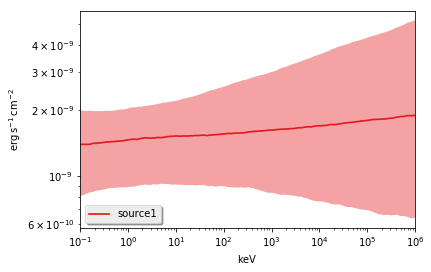

In [23]:
plot_point_source_spectra(jl.results, ene_min=0.1, ene_max=1e6, num_ene=500, 
                          flux_unit='erg / (cm2 s)')

### Bayesian analysis
In a very similar way, we can also perform a Bayesian analysis. As a first step, we need to define the priors for all parameters:

In [30]:
# A uniform prior can be defined directly, like:
new_model.source1.spectrum.main.Powerlaw.index.prior = Uniform_prior(lower_bound=-10, 
                                                                     upper_bound=10)

# or it can be set using the currently defined boundaries
new_model.source1.spectrum.main.Powerlaw.index.set_uninformative_prior(Uniform_prior)

# The same for the Log_uniform prior
new_model.source1.spectrum.main.Powerlaw.K.prior = Log_uniform_prior(lower_bound=1e-3, 
                                                                     upper_bound=100)
# or
new_model.source1.spectrum.main.Powerlaw.K.set_uninformative_prior(Log_uniform_prior)

new_model.display()

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (2):
--------------------

                                         value min_value max_value  \
source1.spectrum.main.Powerlaw.K      0.902672      0.01       100   
source1.spectrum.main.Powerlaw.index  -1.97738       -10        10   

                                                 unit  
source1.spectrum.main.Powerlaw.K      1 / (cm2 keV s)  
source1.spectrum.main.Powerlaw.index                   

Fixed parameters (4):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Then, we can perform our Bayesian analysis like:

In [33]:
bs = BayesianAnalysis(new_model, data)

# This uses the emcee sampler
samples = bs.sample(n_walkers=30, burn_in=100, n_samples=1000)


Mean acceptance fraction: 0.613633333333

Maximum a posteriori probability (MAP) point:



,Value,Unit
source1.spectrum.main.Powerlaw.K,(8.4 -1.9 +7) x 10^-1,1 / (cm2 keV s)
source1.spectrum.main.Powerlaw.index,-1.96 -0.10 +0.04,



Values of -log(posterior) at the minimum:



,-log(posterior)
ogip,-181.706274
total,-181.706274


The BayesianAnalysis object will now have a "results" member which will work exactly the same as explained for the Maximum Likelihood analysis (see above):

In [35]:
bs.results.display()

Maximum a posteriori probability (MAP) point:



,Value,Unit
source1.spectrum.main.Powerlaw.K,(8.4 -1.9 +7) x 10^-1,1 / (cm2 keV s)
source1.spectrum.main.Powerlaw.index,-1.96 -0.10 +0.04,



Values of -log(posterior) at the minimum:



,-log(posterior)
ogip,-181.706274
total,-181.706274


In [37]:
fluxes_bs = bs.results.get_point_source_flux(100 * u.keV, 1 * u.MeV)

,flux
source1: total,(3.9 -1.8 +2.9) x 10^-9 erg / (cm2 s)


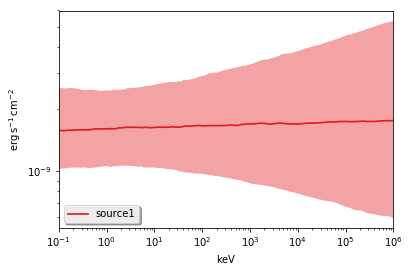

In [38]:
plot_point_source_spectra(bs.results, ene_min=0.1, ene_max=1e6, num_ene=500, 
                          flux_unit='erg / (cm2 s)')

We can also produce easily a "corner plot", like:

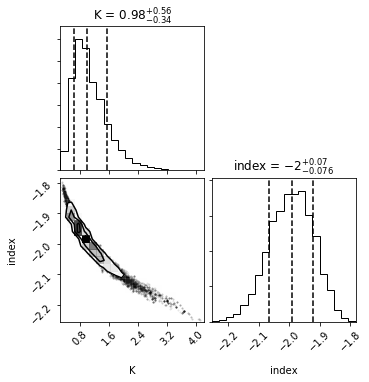

In [40]:
bs.corner_plot()